In [58]:
import pandas as pd
import numpy as np
import sys
sys.path.append("/home/mizworski/Repos/xgboost/python-package/")
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.utils.validation import column_or_1d
from scipy import interp
from scipy import stats

In [239]:
date_parse_format = '%Y-%m-%d'
def age2class(age):
    if age < 20:
        return 0
    if age < 27:
        return 1
    
    if age < 32:
        return 2
    if age < 36:
        return 3
    
    if age < 42:
        return 4
    
    if age < 55:
        return 5
    if age < 75:
        return 6
    return 7

def preprocess_data(data):
    now = datetime.strptime(data.contact_date.max(), date_parse_format)
    data['age'] = data.apply(lambda r: int((now - datetime.strptime(r.birth_date, date_parse_format)).days / 365.25), axis=1)
    data.drop('birth_date', axis=1, inplace=True)
#     data['contact_weekday'] = data.apply(lambda r: (datetime.strptime(r.contact_date, date_parse_format)).weekday(), axis=1)
    
    data['age_range'] = data['age'].apply(age2class)
#     data.drop('age', axis=1, inplace=True)11
    
    categorical_cols = list(set(data.columns) - set(['birth_date', 'contact_date', 'pdays', 'campaign', 'y','age']))
    X = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
    X['contacted'] = pd.get_dummies(X.pdays < 999, drop_first=True)
    
    X['days_since_contact'] =  X.apply(lambda r: int((now - datetime.strptime(r.contact_date, date_parse_format)).days), 
                                       axis=1)
    
    X.drop('contact_date', axis=1, inplace=True)
    
    train_x = X[X.y != 'unknown']
    test_x = X[X.y == 'unknown']
    train_y = train_x['y']
    train_y = pd.get_dummies(train_y, drop_first=True)
    train_x = train_x.drop('y', axis=1)
    test_x = test_x.drop('y', axis=1)
    
#     train_y = column_or_1d(train_y)
#     train_x = train_x.as_matrix()
#     test_x = test_x.as_matrix()
    
    return train_x, train_y, test_x
    

In [240]:
X_train.head()

,campaign,pdays,age,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,poutcome_nonexistent,poutcome_success,contacted,days_since_contact
id,,,,,,,,,,,,,,,,,,,,,
10155,3,999,54,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,887
33815,1,999,49,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,559
18182,6,999,60,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,860
13139,1,999,55,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,874
18165,1,999,36,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,867


In [241]:
X_train.days_since_contact.describe()

count    20799.000000
mean       741.686379
std        206.898946
min          0.000000
25%        575.000000
50%        840.000000
75%        896.000000
max        943.000000
Name: days_since_contact, dtype: float64

In [242]:
df = pd.read_csv('../data/bank-classification.csv', index_col=0)
df = df.sample(frac=1)
X_train, Y_train, X_test = preprocess_data(df)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from numpy import random
from sklearn.preprocessing import PolynomialFeatures

In [243]:
poly = PolynomialFeatures(interaction_only=True)
# X_train = poly.fit_transform(X_train)
# X_test = poly.fit_transform(X_test)
# X_train = X_train.as_matrix()

In [244]:
# X_train = X_train.as_matrix()

In [245]:
X_train.head()

,campaign,pdays,age,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,poutcome_nonexistent,poutcome_success,contacted,days_since_contact
id,,,,,,,,,,,,,,,,,,,,,
15090,1,999,29,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,859
7051,3,999,43,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,943
9600,1,999,38,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,890
32245,2,999,29,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,578
17931,5,999,48,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,882


In [246]:
model = XGBClassifier()
cv = StratifiedKFold(n_splits=6)

X = X_train.as_matrix()
Y = column_or_1d(Y_train)

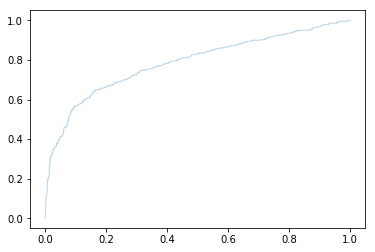

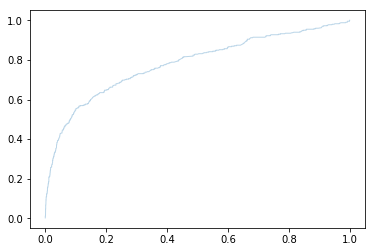

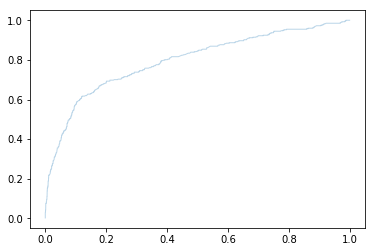

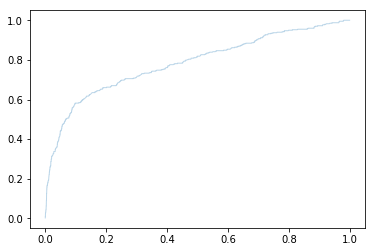

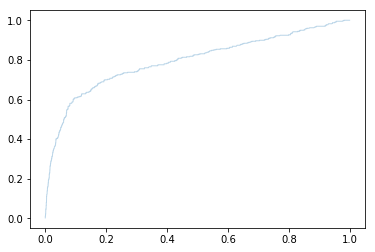

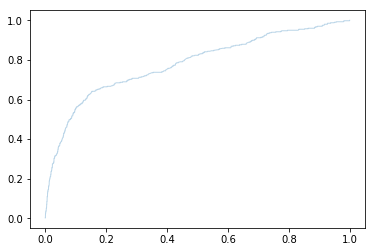

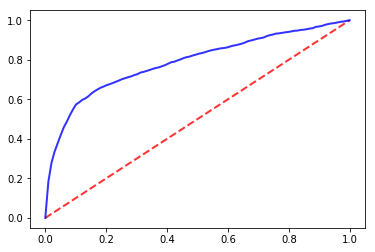

In [247]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i=0

for train, test in cv.split(X, Y):
    probas_ = model.fit(X[train], Y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    plt.show()

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

plt.show()

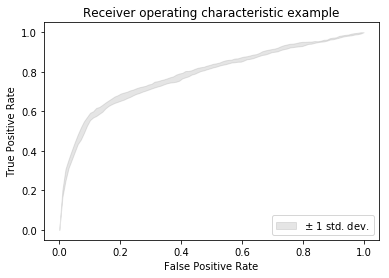

In [248]:
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [249]:
mean_auc

0.7867031594423608

In [250]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v/total for k,v in imp_dict.items()}

In [251]:
X_train.head()

,campaign,pdays,age,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,poutcome_nonexistent,poutcome_success,contacted,days_since_contact
id,,,,,,,,,,,,,,,,,,,,,
15090,1,999,29,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,859
7051,3,999,43,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,943
9600,1,999,38,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,890
32245,2,999,29,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,578
17931,5,999,48,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,882


In [252]:
# model.fit(X, Y)
# get_xgb_imp(model,X_train.columns)

In [253]:
from xgboost import plot_importance

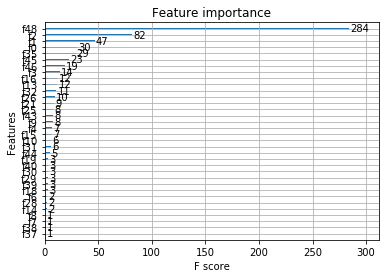

In [254]:
plot_importance(model)
plt.show()

In [255]:
fscore = model.get_booster().get_fscore().items()
fscore = sorted(fscore,key=lambda x:(-x[1],x[0]))
for key, score in fscore:
    fname = X_train.columns[int(key[1:])]
    print('feature: {} score={}'.format(fname, score))

feature: days_since_contact score=284
feature: age score=82
feature: pdays score=47
feature: campaign score=30
feature: contact_telephone score=29
feature: poutcome_nonexistent score=23
feature: poutcome_success score=19
feature: job_blue-collar score=14
feature: job_unknown score=12
feature: default_unknown score=12
feature: age_range_5 score=11
feature: marital_single score=10
feature: previous_4 score=9
feature: marital_married score=8
feature: education_university.degree score=8
feature: job_services score=8
feature: housing_yes score=7
feature: job_entrepreneur score=7
feature: job_student score=6
feature: age_range_4 score=6
feature: education_unknown score=5
feature: previous_1 score=3
feature: previous_2 score=3
feature: age_range_2 score=3
feature: age_range_3 score=3
feature: education_basic.9y score=3
feature: education_high.school score=3
feature: housing_unknown score=2
feature: age_range_1 score=2
feature: job_management score=2
feature: loan_yes score=1
feature: educatio

In [238]:
X_train.columns

Index(['campaign', 'pdays', 'age', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'housing_unknown', 'housing_yes', 'default_unknown',
       'default_yes', 'previous_1', 'previous_2', 'previous_3', 'previous_4',
       'previous_5', 'previous_6', 'previous_7', 'marital_married',
       'marital_single', 'marital_unknown', 'contact_telephone',
       'loan_unknown', 'loan_yes', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'poutcome_nonexistent', 'poutcome_success',
       'contacted', 'days_since_contact'],
      dtype='object')